In [1]:
import sys
sys.path.insert(0, './utils/')


import glob
import time

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import cv2
from PIL import Image
from moviepy.editor import VideoFileClip

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from skimage.measure import label
from skimage.feature import hog

seed = 0

In [2]:
class Config():
    window = 64 # Sliding window width and height
    
    # Hyperparameters for feature extraction:
    color_space = 'YCrCb' # Can be RGB, HSV or YCrCb
    spatial_size = (16, 16) # Spatial binning dimensions
    hist_bins = 16   # Number of histogram bins
    orient = 9 # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

    # Whether to extract certain features:
    spatial_feat = True # Spatial features on or off
    hist_feat = True # Histogram features on or off
    hog_feat = True # HOG features on or off
    
    # Search ranges and scale factors:
    y_start_stops = [(400, 464), (400, 496), (432, 560), (448, 644)] # Min and max in y to search in sliding window
    scales = [1, 1.5, 2., 3.]

In [3]:
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))


def color_hist(img, nbins=32, bins_range=(0, 255)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm = 'L2-Hys',
                                  transform_sqrt=True, 
                                  visualize=vis, feature_vector=feature_vec)
        return features, hog_image
    
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm = 'L2-Hys',
                       transform_sqrt=True, 
                       visualize=vis, feature_vector=feature_vec)
        return features

In [4]:

def convert_colorspace(img, color_space='RGB'):
    if color_space == 'RGB':
        feature_image = np.copy(img)      
    elif color_space == 'HSV':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    elif color_space == 'YCrCb':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else:
        raise ValueError('Color space is not found.')
        
    return feature_image


def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap


def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap < threshold] = 0
    heatmap[heatmap > 0] = 1
    # Return thresholded map
    return heatmap


def draw_labeled_bboxes(img, labels):
    box_list = []
    
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        box_list.append(bbox)

    # Draw boxes on the image
    out_img = draw_boxes(img, box_list, color=(0, 0, 255), thick=6)
        
    return out_img


def extract_features(imgs, color_space='RGB', spatial_size=(32, 32), hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    
    # Create a list to append feature vectors to
    features = []
    
    # Iterate through the list of images
    for image in imgs:
        file_features = []
        
        # Read in each one by one
        #image = np.asarray(Image.open(file))
        
        # apply color conversion if other than 'RGB'
        feature_image = convert_colorspace(image, color_space)
            
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
            
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
            
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
                
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        
        if len(file_features) == 0:
            raise ValueError('Feature vector is empty.')
            
        features.append(np.concatenate(file_features))
        
    # Return list of feature vectors
    return features


def find_cars(img, svc, X_scaler, y_start_stops, scales, window, color_space, spatial_size, hist_bins, orient, pix_per_cell, cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat):
    
    box_list = []
    
    for scale, (y_start, y_stop) in zip(scales, y_start_stops):
        img_tosearch = img[y_start:y_stop,:,:]
        #ctrans_tosearch = convert_colorspace(img_tosearch, color_space=color_space)

        if scale != 1:
            imshape = img_tosearch.shape
            img_tosearch = cv2.resize(img_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

        nxsteps = (img_tosearch.shape[1] - window) // pix_per_cell + 1
        nysteps = (img_tosearch.shape[0] - window) // pix_per_cell + 1

        for xc in range(nxsteps):
            for yc in range(nysteps):
                xleft = xc * pix_per_cell
                ytop = yc * pix_per_cell

                # Extract the image patch
                subimg = img_tosearch[ytop:ytop+window, xleft:xleft+window]

                # Extract features and make a prediction
                test_features = X_scaler.transform(extract_features([subimg], 
                                                                    color_space, spatial_size,
                                                                    hist_bins, orient,
                                                                    pix_per_cell, cell_per_block,
                                                                    hog_channel, spatial_feat,
                                                                    hist_feat, hog_feat))
                
                test_prediction = svc.predict(test_features)

                if test_prediction[0] == 1:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    bbox = ((xbox_left, ytop_draw+y_start), (xbox_left+win_draw, ytop_draw+win_draw+y_start))
                    box_list.append(bbox)
                    
        out_img = draw_boxes(img, box_list, color=(0, 0, 255), thick=6)
                    
    return out_img, box_list

In [7]:
cars = glob.glob('/content/dataset/vehicles/*.*')
num_car_image = len(cars)

notcars = glob.glob('/content/dataset/non-vehicles/*.*')
num_not_car_image = len(notcars)

print('# car images:', num_car_image, '\n# non-car images:', num_not_car_image)

# car images: 159 
# non-car images: 102


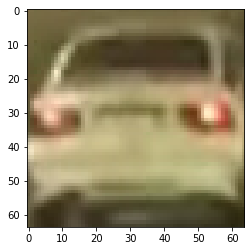

In [8]:
image_test1 = np.asarray(Image.open(cars[0]))
plt.imshow(image_test1)

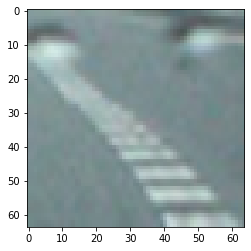

In [9]:
image_test2 = np.asarray(Image.open(notcars[0]))
plt.imshow(image_test2)


In [10]:
for i in range(len(cars)):
    cars[i] = np.asarray(Image.open(cars[i]))

for i in range(len(notcars)):
    notcars[i] = np.asarray(Image.open(notcars[i]))

In [11]:
car_features = extract_features(cars, 
                                Config.color_space, Config.spatial_size, 
                                Config.hist_bins, Config.orient,
                                Config.pix_per_cell, Config.cell_per_block,
                                Config.hog_channel, Config.spatial_feat,
                                Config.hist_feat, Config.hog_feat)

notcar_features = extract_features(notcars,
                                   Config.color_space, Config.spatial_size,
                                   Config.hist_bins, Config.orient,
                                   Config.pix_per_cell, Config.cell_per_block,
                                   Config.hog_channel, Config.spatial_feat,
                                   Config.hist_feat, Config.hog_feat)


In [10]:
len(car_features)


102

In [11]:
len(notcar_features)

102

In [12]:
len(car_features[101])

64320

In [13]:
def largest(arr,n):
  
    # Initialize maximum element
    max = len(arr[0])
  
    # Traverse array elements from second
    # and compare every element with 
    # current max
    for i in range(1, n):
        if len(arr[i]) > max:
            max = len(arr[i])
    return max

In [23]:
n = len(car_features)
h = largest(car_features, n)

In [15]:
def padarray(A, size):
    t = size - len(A)
    return np.pad(A, pad_width=(0, t), mode='constant')


In [16]:

car_features1 =[]
for i in range(n):
  car_features1.append( padarray(car_features[i], h))

In [18]:
len(car_features1[100])

417048

In [24]:
n = len(notcar_features)


In [25]:

notcar_features1 =[]
for i in range(n):
  notcar_features1.append( padarray(notcar_features[i], h))

In [13]:

X = np.vstack((car_features, notcar_features)).astype(np.float64) 


In [15]:

y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

In [16]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=seed)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)

# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

if Config.hist_feat:
    print('Using:', Config.hist_bins, 'bins for color histogram feature.')

if Config.hog_feat:
    print('Using:', Config.orient, 'orientations,', Config.pix_per_cell,
        'pixels per cell, and', Config.cell_per_block, 'cells per block for HOG feature.')
    
print('Feature vector length:', len(X_train[0]))

Using: 16 bins for color histogram feature.
Using: 9 orientations, 8 pixels per cell, and 2 cells per block for HOG feature.
Feature vector length: 6108


In [17]:
# Use a linear SVC 
parameters = {
    'C': np.logspace(-5, 5, 10)
}

gs_svc = GridSearchCV(LinearSVC(), parameters, cv=3)

t=time.time()
gs_svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

svc = gs_svc.best_estimator_
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

2.05 Seconds to train SVC...
Test Accuracy of SVC =  1.0


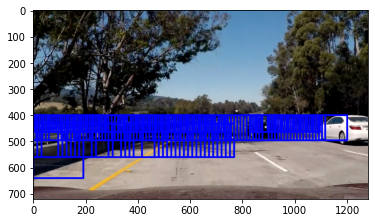

In [19]:
img = np.asarray(Image.open('dataset/test/test5.jpg'))
out_img, box_list = find_cars(img, svc, X_scaler, Config.y_start_stops, Config.scales, Config.window,
                              Config.color_space, Config.spatial_size,
                              Config.hist_bins, Config.orient,
                              Config.pix_per_cell, Config.cell_per_block,
                              Config.hog_channel, Config.spatial_feat,
                              Config.hist_feat, Config.hog_feat)

plt.imshow(out_img)
